<a href="https://colab.research.google.com/github/chupvl/gcolab/blob/main/2023_01_03_proteome_drugs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2023-01-03: Comments on paper "A proteome-wide atlas of drug mechanism of action"

## Libs

In [1]:
!pip install rdkit-pypi -qqq

In [2]:
import pandas as pd
# 
from rdkit import Chem
from rdkit.Chem import PandasTools

from rdkit.Chem import Draw
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs

def show_df(df):
    return HTML(df.to_html(notebook=True))

def getMol(smiles):
  try:
    return Chem.MolFromSmiles(smiles)
  except:
    return None

def getSim(m1, m2):
  fp1 = FingerprintMols.FingerprintMol(m1)
  fp2 = FingerprintMols.FingerprintMol(m2)
  return DataStructs.TanimotoSimilarity(fp1, fp2)

def get_mscaffold(mol):
  '''
  for a given rdkit.Mol return Murcko scaffold and its inchikey
  '''
  try:
    Chem.RemoveStereochemistry(mol)
    sk = Chem.Scaffolds.MurckoScaffold.GetScaffoldForMol(mol)
    return sk, Chem.inchi.MolToInchiKey(sk)
  except:
    return None, None
#


In [3]:
def getDataForComps(lst_names):
  smiles = [dfs2[dfs2['Compound Name'].str.contains(i)]['SMILES'].values[0] for i in lst_names]
  mols = [getMol(s) for s in smiles]
  sims = [getSim(i, mols[0]) for i in mols]
  D = {}
  D['names'] = lst_names
  D['mols'] = mols
  D['sims'] = [round(i, 4) for i in sims]
  D['prots'] = len(dfs1_mlt[(dfs1_mlt['value_abs'] > 1) & (dfs1_mlt['variable'].str.contains(lst_names[0]))]['Gene Name'].to_list())
  return D

In [4]:
def getImage(DataForComps):
  legend = [str(i) for i in DataForComps['sims']]
  legend = [' '.join(i) for i in list(zip(DataForComps['names'], legend))]
  legend[0] = DataForComps['names'][0]
  return Draw.MolsToGridImage(DataForComps['mols'], molsPerRow=5, subImgSize=(200,200), legends=legend)

In [5]:
def getProteins(CompoundName, cutoff=1):
  propt_lst = dfs1_mlt[(dfs1_mlt['variable'].str.contains(CompoundName)) & (dfs1_mlt['value_abs'] > cutoff)]['Gene Name'].to_list()
  return propt_lst

In [6]:
def get_ez_stats(df_mlt, cutoff=-0.5):
  cmps_vc = df_mlt[df_mlt['value'] <= cutoff]['variable'].value_counts()
  cmps_vc = cmps_vc.reset_index()
  cmps_vc.columns = ['entity', 'nTProteins']
  cmps_vc['Compound Name'] = [i.split('_')[0] for i in cmps_vc['entity']]
  cmps_ezstats = cmps_vc.merge(dfs2, on='Compound Name')
  return cmps_ezstats

## Data

In [7]:
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-022-01539-0/MediaObjects/41587_2022_1539_MOESM3_ESM.csv

--2023-01-14 03:39:06--  https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-022-01539-0/MediaObjects/41587_2022_1539_MOESM3_ESM.csv
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43215683 (41M) [text/csv]
Saving to: ‘41587_2022_1539_MOESM3_ESM.csv.2’

41587_2022_1539_MOE 100%[===================>]  41.21M  --.-KB/s    in 0.1s    

2023-01-14 03:39:06 (289 MB/s) - ‘41587_2022_1539_MOESM3_ESM.csv.2’ saved [43215683/43215683]



In [8]:
# profiles
dfs1 = pd.read_csv('41587_2022_1539_MOESM3_ESM.csv', encoding='unicode_escape')
# ok, those are compounds with smiles
dfs2 = pd.read_excel('https://static-content.springer.com/esm/art%3A10.1038%2Fs41587-022-01539-0/MediaObjects/41587_2022_1539_MOESM4_ESM.xlsx', dtype=str)
Chem.PandasTools.AddMoleculeColumnToFrame(dfs2, 'SMILES', 'mol', includeFingerprints=True)

In [9]:
# checking compound names
dfs1_cn = set([ i.split('_')[0] for i in dfs1.columns[2:] ])
dfs2_cn = set(dfs2['Compound Name'])
dfs1_cn.difference(dfs2_cn)
# skipping compound-compound mapping issues for now
cn_ovlp = list(dfs1_cn & dfs2_cn)
print(f'Number of compounds for analysis: {len(cn_ovlp)}')

Number of compounds for analysis: 872


In [10]:
# most of the compounds were screened in 10uM concentration
dfs2['Screening Concentration'].value_counts()

10uM    847
1uM      28
Name: Screening Concentration, dtype: int64

## Proteome fingerprint

In [11]:
# checking if the same gene name is mapped to several UniprotIDs
# UniprotID is a unique protein identifier, gene symbol is not
nUUID = len(set(dfs1['UniprotID']))
nUGN = len(set(dfs1['Gene Name']))
print(f'Numer of unique gene names: {nUUID}')
print(f'Numer of unique uniprot IDs: {nUGN}')
print(f'Total number of entries: {len(dfs1)}')

Numer of unique gene names: 9960
Numer of unique uniprot IDs: 9715
Total number of entries: 9960


In [12]:
# that would be easier to handle
dfs1_mlt = pd.melt(dfs1, id_vars=['Gene Name', 'UniprotID'])
dfs1_mlt['value_abs'] = dfs1_mlt['value'].abs()
dfs1_mlt.head()

,Gene Name,UniprotID,variable,value,value_abs
0,AAAS,Q9NRG9,SR 142948_NTSR1,0.00,0.00
1,AACS,Q86V21,SR 142948_NTSR1,-0.03,0.03
2,AADAT,Q8N5Z0-2,SR 142948_NTSR1,0.02,0.02
3,AAGAB,Q6PD74,SR 142948_NTSR1,0.16,0.16
4,AAK1,Q2M2I8,SR 142948_NTSR1,-0.02,0.02


In [13]:
cmps_m05_ezstats = get_ez_stats(dfs1_mlt)
cmps_m05_ezstats[cmps_m05_ezstats['nTProteins'] > 50]['Primary Target'].value_counts()

PTK2        3
PIK3CA      3
BRD4        3
CDK4        3
MDM2        3
           ..
EWSR1       1
CHEK1       1
ABL1;SRC    1
TYK2        1
PSEN1       1
Name: Primary Target, Length: 166, dtype: int64

In [14]:
cmps_m1_ezstats = get_ez_stats(dfs1_mlt, -1)
cmps_m1_ezstats = cmps_m1_ezstats[['nTProteins', 'Compound Name', 'Primary Target']]
cmps_m1_ezstats['Primary Target'] = cmps_m1_ezstats['Primary Target'].str.split(';')
cmps_m1_ezstats = cmps_m1_ezstats.explode('Primary Target').sort_values('Primary Target').reset_index(drop=True)
cmps_m1_ezstats[cmps_m1_ezstats['nTProteins'] > 50]['Primary Target'].value_counts().index

Index(['HDAC1', 'PIK3CA', 'BRD4', 'MDM2', 'ABL1', 'PTK2', 'KIF11', 'PLK1',
       'HDAC3', 'HDAC6', 'PSMB5', 'HSP90AA1', 'FLT3', 'RAF1', 'IGF1R', 'SYK',
       'JAK2', 'NAE1', 'MELK', 'MAPK1', 'MAP2K1', 'LCK', 'MTOR', 'PLD2',
       'OXTR', 'PAK4', 'PRKD1', 'PRKDC', 'PSMB8', 'RXRB', 'SLC6A3', 'SRC',
       'SSRP1', 'STAT6', 'TOP1', 'TTK', 'VCP', 'KIT', 'JAK1', 'KDR', 'CXCR2',
       'AKT2', 'ATP6V1H', 'AURKB', 'BCL2L1', 'BRAF', 'CDC7', 'CDK2', 'CDK4',
       'CDK9', 'CENPE', 'CHEK1', 'CTNNB1', 'DHODH', 'KDM1A', 'EHMT1', 'EHMT2',
       'EPHB4', 'EWSR1', 'FGFR1', 'GHSR', 'GPER1', 'HSP90B1', 'IKBKB', 'IL1B',
       'IMPDH2', 'ADRA2C', 'XPO1'],
      dtype='object')

In [15]:
cmps_m1_ezstats[cmps_m1_ezstats['nTProteins'] > 100]['Primary Target'].value_counts().head(20)

HDAC1     3
MDM2      3
BRD4      3
PLK1      2
RAF1      2
PIK3CA    2
HDAC6     2
PTK2      2
IGF1R     2
KIF11     2
FLT3      2
OXTR      1
PLD2      1
NAE1      1
PAK4      1
MELK      1
MAPK1     1
ABL1      1
LCK       1
PRKD1     1
Name: Primary Target, dtype: int64

In [16]:
cmps_m1_ezstats[cmps_m1_ezstats['Primary Target'] == 'OXTR']

,nTProteins,Compound Name,Primary Target
541,123,CHEMBL200403,OXTR


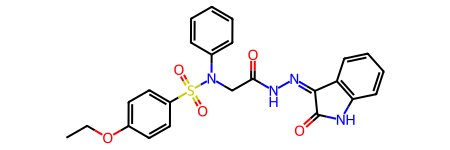

In [17]:
CHEMBL200403 = dfs2[dfs2['Compound Name'] == 'CHEMBL200403']['SMILES'].values[0]
Chem.MolFromSmiles(CHEMBL200403)
# S is for suspicious

## Case 1: RN486

In [18]:
case1_d = getDataForComps(['RN486', 'SB-224289', 'UNC 0638', 'Cediranib', 'STK410283'])
case1_d

{'names': ['RN486', 'SB-224289', 'UNC 0638', 'Cediranib', 'STK410283'],
 'mols': [<rdkit.Chem.rdchem.Mol at 0x7fb8920cf040>,
 'sims': [1.0, 0.5721, 0.4398, 0.442, 0.4042],
 'prots': 88}

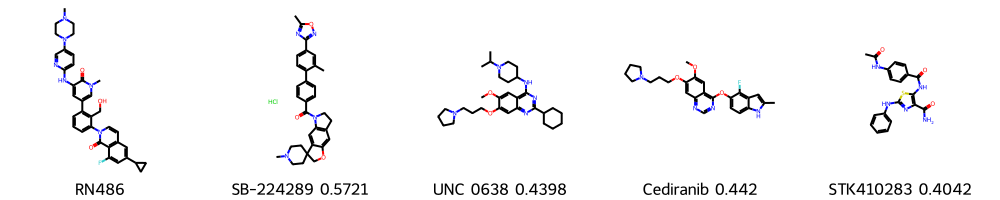

In [19]:
getImage(case1_d)

## Case 2: JP1302

In [20]:
case2_d = getDataForComps(['JP1302', 'Flavopiridol', 'AZD-5438', 'PHA 767491', 'CBL0137'])
case2_d

{'names': ['JP1302', 'Flavopiridol', 'AZD-5438', 'PHA 767491', 'CBL0137'],
 'mols': [<rdkit.Chem.rdchem.Mol at 0x7fb8920cf5f0>,
 'sims': [1.0, 0.4152, 0.4179, 0.3753, 0.4088],
 'prots': 672}

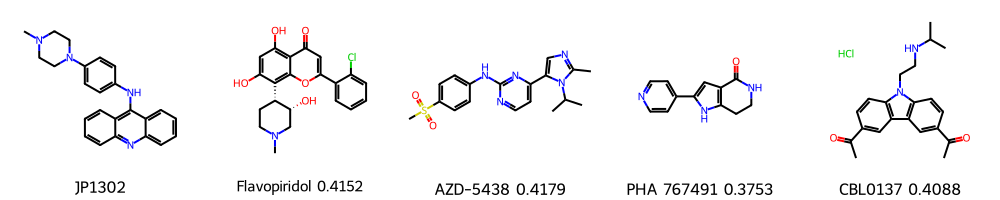

In [21]:
getImage(case2_d)

## Case 3: nutlin3a

In [22]:
case3_d = getDataForComps(['Nutlin3a', 'Idasanutlin', 'MI-773', 'UNC2250'])
case3_d

{'names': ['Nutlin3a', 'Idasanutlin', 'MI-773', 'UNC2250'],
 'mols': [<rdkit.Chem.rdchem.Mol at 0x7fb8920cfac0>,
 'sims': [1.0, 0.5459, 0.5679, 0.3899],
 'prots': 365}

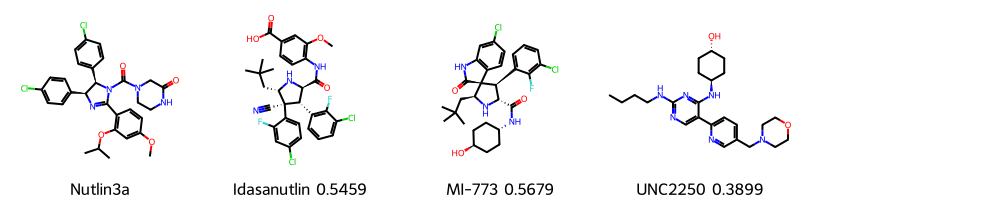

In [23]:
getImage(case3_d)

## Case 4: Identical Murcko scaffolds

In [24]:
# adding scaffold information
dfs2[['scaffold_mol', 'scaffold_inchikey']] = [get_mscaffold(i) for i in dfs2['mol'].values ]

In [25]:
# taking compounds with identical scaffolds
dfs2_ik_dupl = dfs2.dropna(subset=['scaffold_inchikey'], how='any')
dfs2_ik_dupl = dfs2_ik_dupl[dfs2_ik_dupl['scaffold_inchikey'] != '']
dfs2_ik_dupl = dfs2_ik_dupl[dfs2_ik_dupl['scaffold_inchikey'].duplicated()].reset_index(drop=True)

In [26]:
# let's check how big scaffold are in duplicated scaffolds
# we are definitely interested in >6 atoms per scaffold
dfs2_ik_dupl['scaffold_mol_nHAtoms'] = [m.GetNumHeavyAtoms() for m in dfs2_ik_dupl['scaffold_mol']]
dfs2_ik_dupl['scaffold_mol_nHAtoms'].value_counts()

6     46
17     9
16     7
13     6
9      5
18     5
11     4
24     3
14     3
26     3
5      3
10     2
12     2
25     2
19     2
29     2
28     2
30     1
21     1
35     1
15     1
40     1
23     1
20     1
Name: scaffold_mol_nHAtoms, dtype: int64

In [27]:
skik_g6 = dfs2_ik_dupl[dfs2_ik_dupl['scaffold_mol_nHAtoms'] > 6]['scaffold_inchikey'].value_counts()
top_scaffolds_ik = skik_g6[skik_g6 >=2 ].index.to_list()
print(f'Number of compounds with duplicated Murcko scaffold: {len(top_scaffolds_ik)}')

Number of compounds with duplicated Murcko scaffold: 11


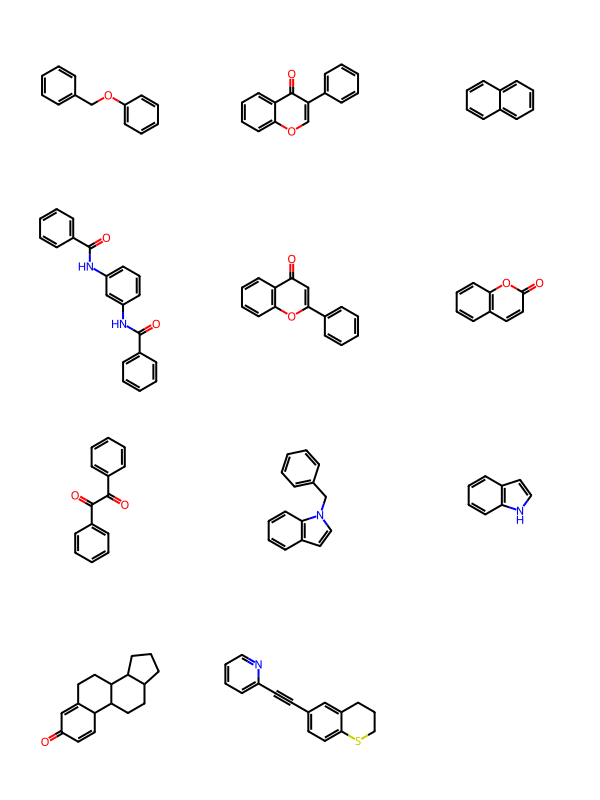

In [28]:
# let's see them
top_scaffolds_exmpls = dfs2_ik_dupl[dfs2_ik_dupl['scaffold_inchikey'].isin(top_scaffolds_ik)].drop_duplicates(subset=['scaffold_inchikey'])
top_scaffolds_exmpls_ik = top_scaffolds_exmpls['scaffold_inchikey'].to_list()
Draw.MolsToGridImage(top_scaffolds_exmpls['scaffold_mol'])
# most of them are not very interesting

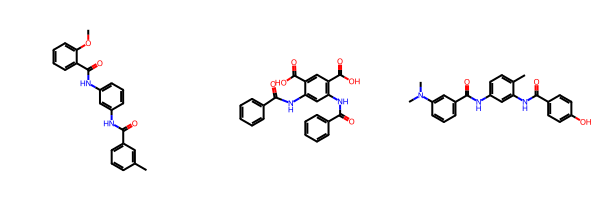

In [29]:
Draw.MolsToGridImage(dfs2[dfs2['scaffold_inchikey'] == top_scaffolds_exmpls_ik[3]]['mol'])
# nope, pharmacophore is drastically different

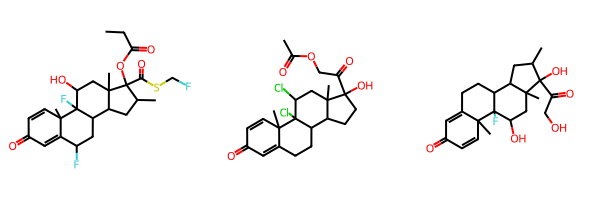

In [30]:
Draw.MolsToGridImage(dfs2[dfs2['scaffold_inchikey'] == top_scaffolds_exmpls_ik[-2]]['mol'])
# that might be interesting, but steroids are always tricky

In [31]:
#case4_example0 = dfs2[dfs2['scaffold_inchikey'] == top_scaffolds_exmpls_ik[-2]]['Compound Name'].to_list()
#case4_example0_prots_g10 = {k: set(getProteins(k, 1)) for k in case4_example0}

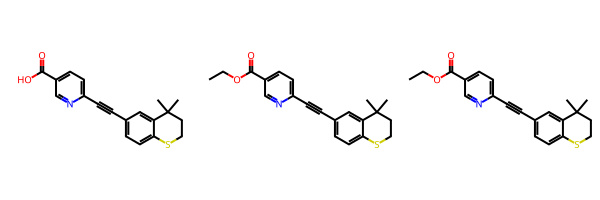

In [32]:
Draw.MolsToGridImage(dfs2[dfs2['scaffold_inchikey'] == top_scaffolds_exmpls_ik[-1]]['mol'])
# yep, that's interesting
# not sure why they have Tazarotene and Tazarotene1	 and Tazarotene2 names

### Case 4: identical Murcko scaffolds - example 1

In [33]:
case4_example1 = ['AGN 190299', 'Tazarotene1', 'Tazarotene2']

In [34]:
dfs2.columns

Index(['Compound Name', 'Primary Target', 'Secondary Target', 'SMILES', 'MW',
       'Formula', 'Screening Concentration', 'mol', 'scaffold_mol',
       'scaffold_inchikey'],
      dtype='object')

In [35]:
dfs2[dfs2['Compound Name'].isin(case4_example1)][['Compound Name', 'Primary Target', 'Secondary Target', 'MW', 'Formula', 'Screening Concentration', ]]

,Compound Name,Primary Target,Secondary Target,MW,Formula,Screening Concentration
59,AGN 190299,RARB,NaN,323.1,C19H17NO2S,10uM
559,Tazarotene1,RARB,RARG;RARA,351.13,C21H21NO2S,10uM
569,Tazarotene2,RARB,RARG;RARA,351.13,C21H21NO2S,10uM


In [36]:
case4_example1_prots_g05 = {k: set(getProteins(k, 0.5)) for k in case4_example1}
case4_example1_prots_g10 = {k: set(getProteins(k, 1)) for k in case4_example1}
for k,v in case4_example1_prots_g05.items():
  print(f'Number of proteins for {k} at 0.5 cutoff: {len(v)}')
  print(f'Number of proteins for {k} at 1.0 cutoff: {len(case4_example1_prots_g10[k])}')
  print('\n')

Number of proteins for AGN 190299 at 0.5 cutoff: 18
Number of proteins for AGN 190299 at 1.0 cutoff: 1


Number of proteins for Tazarotene1 at 0.5 cutoff: 23
Number of proteins for Tazarotene1 at 1.0 cutoff: 4


Number of proteins for Tazarotene2 at 0.5 cutoff: 30
Number of proteins for Tazarotene2 at 1.0 cutoff: 6




In [37]:
case4_example1_prots_g10['Tazarotene1'] & case4_example1_prots_g10['Tazarotene2']
# that's really weird

set()

In [38]:
case4_example1_prots_g05['Tazarotene1'] & case4_example1_prots_g05['Tazarotene2']
# that's a bit better

{'CYP1A1', 'NRIP1', 'PLIN2'}

In [39]:
case4_example1_prots_g05['AGN 190299'] & case4_example1_prots_g05['Tazarotene1']

set()

In [40]:
case4_example1_prots_g05['AGN 190299'] & case4_example1_prots_g05['Tazarotene2']

{'DHRS3', 'ELF3', 'KLK6', 'LTBP3'}

So, for three compounds of which two are duplicates we have following:
- duplicates does not have overlapping proteins at 1.0 log units cutoffs (absolute values)
- duplicates does have some overlapping proteins at 0.5 log units cutoffs (absolute values)
- "AGN 190299" that is a "parent" compound for Tazarotene does not have overlapping proteins with Tazarotene1, but does have overlapping proteins with Tazarotene2
- A very strange issue... 

## HCT116 proteome

In [41]:
# compound is quit a hurricane
dfs1_mlt[(dfs1_mlt['value_abs'] > 2) & (dfs1_mlt['variable'].str.contains('Nutlin3a'))]

,Gene Name,UniprotID,variable,value,value_abs
7679319,ADAMTS7,Q9UKP4,Nutlin3a_MDM2,2.04,2.04
7679563,ANLN,Q9NQW6,Nutlin3a_MDM2,-3.68,3.68
7679668,ARHGAP11A,Q6P4F7,Nutlin3a_MDM2,-2.46,2.46
7679672,ARHGAP19,Q14CB8-2,Nutlin3a_MDM2,-2.80,2.80
7679708,ARHGEF39,Q8N4T4,Nutlin3a_MDM2,-2.30,2.30
...,...,...,...,...,...
7688260,UBE2T,Q9NPD8,Nutlin3a_MDM2,-2.26,2.26
7688318,UHRF1,Q96T88-2,Nutlin3a_MDM2,-2.19,2.19
7688394,USP37,Q86T82,Nutlin3a_MDM2,-2.69,2.69
7688581,WDR76,Q9H967,Nutlin3a_MDM2,-3.90,3.90


In [42]:
!wget -O cl_proteome.txt https://www.ebi.ac.uk/gxa/experiments-content/E-PROT-19/download/PROTEOMICS_BASELINE?geneQuery=%5B%5D&unit=parts+per+billion&cutoff=0.0&selectedColumnIds=g1%2Cg2%2Cg3%2Cg4%2Cg5&type=PROTEOMICS_BASELINE 

--2023-01-14 03:39:54--  https://www.ebi.ac.uk/gxa/experiments-content/E-PROT-19/download/PROTEOMICS_BASELINE?geneQuery=%5B%5D
Resolving www.ebi.ac.uk (www.ebi.ac.uk)... 193.62.193.80
Connecting to www.ebi.ac.uk (www.ebi.ac.uk)|193.62.193.80|:443... connected.
HTTP request sent, awaiting response... 200 
Length: unspecified [text/plain]
Saving to: ‘cl_proteome.txt’

cl_proteome.txt         [     <=>            ] 639.32K   566KB/s    in 1.1s    

2023-01-14 03:39:56 (566 KB/s) - ‘cl_proteome.txt’ saved [654664]



In [43]:
df_HCT116 = pd.read_csv('cl_proteome.txt', sep='\t', skiprows=4)
print(df_HCT116.shape)
df_HCT116.head()

(11536, 7)


,Gene ID,Gene Name,A549,HCT116,HeLa,MCF-7,SH-SY5Y
0,ENSG00000000003,TSPAN6,3287.0,4202.0,5610.0,978.0,1105.0
1,ENSG00000000419,DPM1,85916.0,116570.0,135471.0,173859.0,237237.0
2,ENSG00000000457,SCYL3,9725.0,4903.0,1246.0,6427.0,9118.0
3,ENSG00000000460,C1orf112,3912.0,5324.0,4790.0,2402.0,11578.0
4,ENSG00000000971,CFH,3751.0,64.0,5107.0,558.0,55.0


In [44]:
df_HCT116[df_HCT116['Gene Name'].str.contains('ADR')]

,Gene ID,Gene Name,A549,HCT116,HeLa,MCF-7,SH-SY5Y
4588,ENSG00000130706,ADRM1,144803.0,99441.0,171824.0,159340.0,114771.0
6625,ENSG00000150594,ADRA2A,NaN,NaN,2415.0,NaN,NaN
6922,ENSG00000154639,CXADR,39120.0,33064.0,34247.0,267.0,28731.0


In [45]:
df_HCT116[df_HCT116['Gene Name'].str.contains('RAR')]

,Gene ID,Gene Name,A549,HCT116,HeLa,MCF-7,SH-SY5Y
3134,ENSG00000113643,RARS1,375832.0,412980.0,303648.0,406507.0,473539.0
4710,ENSG00000131759,RARA,965.0,2202.0,1114.0,6409.0,3164.0
6318,ENSG00000146282,RARS2,12699.0,16485.0,15949.0,13287.0,21583.0
9017,ENSG00000172819,RARG,1324.0,5268.0,979.0,10221.0,2870.0
